In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import itertools

#fx1 = lambda x1,x2,gamma:(x1**2 + x2 ** 2 * gamma)/2
pi = math.pi
def log(x):
    return math.log(x)
def cos(x):
    return math.cos(x)
def sin(x):
    return math.sin(x)
def exp(x):
    return np.exp(x)
def real(x):
    return np.real(x)
def imag(x):
    return np.imag(x)

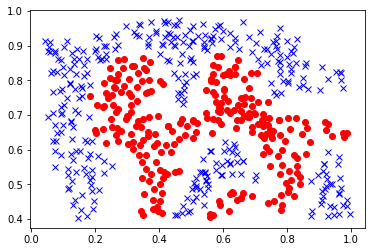

In [6]:
df = pd.read_csv("train_2d.txt", sep=',')
df_x = df[['x1','x2']]
df_y = df['y']
df_sub1 = df[df['y'] == 0]
df_sub2 = df[df['y'] == 1]
plt.plot(df_sub1['x1'],df_sub1['x2'],'ro')
plt.plot(df_sub2['x1'],df_sub2['x2'],'bx')

In [91]:
class NaiveBayesClassifier_cont_input:
    # k : laplace smoothing coeff
    # partitionN : num of partition for x1 each
    def __init__(self, k=0.5,method = 'g-distribution', partitionN = 5):
        self.k = k
        self.partitionN = partitionN
        self.method = method
    def getPartition(self, x):
        intx = int(x * self.partitionN)
        if intx == self.partitionN:
            intx -=1
        return intx
    def getPartition_2d(self, x_list):
        intx1 = int(x_list[0] * self.partitionN)
        if intx1 == self.partitionN:
            intx1 -=1
        intx2 = int(x_list[1] * self.partitionN)
        if intx2 == self.partitionN:
            intx2 -=1
        return intx1*self.partitionN + intx2
    def fit(self, x,y):
        xy = pd.concat([x, y], axis=1)
        #print(xy)
        if self.method == 'g-distribution':
            #x1, x2 ... 에 대해서 가우시안 분포를 만든다.
            m = y.size
            n = x.loc[0].size       
            self.n = n
            ny = y.to_numpy()
            nx = x.to_numpy()
            fx_list = []
            mean_y0_list = []
            mean_y1_list = []
            var_y0_list = []
            var_y1_list = []
            xy_0 = xy[xy['y'] == 0]
            xy_1 = xy[xy['y'] == 1]
            self.py1 = xy_0.shape[0]
            self.py2 = xy_1.shape[0]
            for i in range (0,n):
                
                
                nx_y0_mean = xy_0.iloc[:,i].mean()
                nx_y0_var = xy_0.iloc[:,i].var()
                nx_y1_mean = xy_1.iloc[:,i].mean()
                nx_y1_var = xy_1.iloc[:,i].var()                
                
                mean_y0_list.append(nx_y0_mean)
                var_y0_list.append(nx_y0_var)
                
                mean_y1_list.append(nx_y1_mean)
                var_y1_list.append(nx_y1_var)
                
             #   print(nx_y0_mean,nx_y0_var)
             #   print(nx_y1_mean,nx_y1_var)
                fx1 = lambda x__ : (2* pi * nx_y0_var) ** (-0.5) * exp( -((x__-nx_y0_mean)** 2) /  (2 * nx_y0_var))
                fx2 = lambda x__ : (2* pi * nx_y1_var) ** (-0.5) * exp( -((x__-nx_y1_mean)** 2) /  (2 * nx_y1_var) )                                                    
                fx_list.append((fx1,fx2))
            self.mean_y0_list = mean_y0_list
            self.mean_y1_list = mean_y1_list
            self.var_y0_list = var_y0_list
            self.var_y1_list = var_y1_list
            self.gaussians = fx_list
            
        if self.method == 'equal_partition':
            x_boundary = np.linspace(0, 1, self.partitionN)
            m = y.size
            n = x.loc[0].size       
            prob_ij = np.zeros(self.partitionN*n*2).reshape(self.partitionN,n,2)# + self.k
            #print(prob_ij)
            self.n = n
            
            xy_0 = xy[xy['y'] == 0]
            xy_1 = xy[xy['y'] == 1]
            self.py1 = xy_0.shape[0]
            self.py2 = xy_1.shape[0]
            
            for index, row in xy.iterrows():
                y_row = row[n]
                #print(n,y_row)
                for idx_n,element in enumerate(row[0:n]):
                    int_eli = self.getPartition(element)
                    if y_row == 1:
                        prob_ij[int_eli][idx_n][1]+=1 / self.py2
                    else :
                        prob_ij[int_eli][idx_n][0]+=1 / self.py1
            print(prob_ij)
            self.prob_ij = prob_ij
        
        if self.method == 'equal_partition_2d':
            x_boundary = np.linspace(0, 1, self.partitionN)
            m = y.size
            n = x.loc[0].size       
            prob_ij = np.zeros((self.partitionN**2)*2).reshape(self.partitionN ** 2,2) #+ self.k
            #print(prob_ij)
            self.n = n
            
            xy_0 = xy[xy['y'] == 0]
            xy_1 = xy[xy['y'] == 1]
            self.py1 = xy_0.shape[0]
            self.py2 = xy_1.shape[0]
            
            for index, row in xy.iterrows():
                y_row = row[n]
                #print(n,y_row)
                #for idx_n,element in enumerate(row[0:n]):
                int_eli = self.getPartition_2d(row[0:n])
                if y_row == 1:
                    prob_ij[int_eli][1]+=1 / self.py2
                else :
                    prob_ij[int_eli][0]+=1 / self.py1
            print(prob_ij)
            self.prob_ij = prob_ij   
                
    def classify(self, x):
        if self.method == 'g-distribution':
            mul1 = 1
            mul2 = 1
            for i in range (0,self.n):
                (fx1,fx2) = self.gaussians[i]
                #print( x[i] , fx1(x[i]))
                mul1 = mul1 * fx1(x[i]) 
                mul2 = mul2 * fx2(x[i])
                #print(mul1,mul2)
            summer = mul2 / (mul1+ mul2)
           # print ('finall prob = ' +str(summer))
            return summer
        if self.method == 'equal_partition':
            mul1 = 1
            mul2 = 1
            for i in range (0,self.n):
                mul1 *= self.prob_ij[self.getPartition(x[i]),i,0]
                mul2 *= self.prob_ij[self.getPartition(x[i]),i,1]
            proby1 = self.py1 / (self.py1+self.py2)
            proby2 = self.py2 / (self.py1+self.py2)
            
          #  print( (mul2 * proby2)/ (mul1*proby1 + mul2*proby2))
            return (mul2 * proby2)/ (mul1*proby1 + mul2*proby2)
        if self.method == 'equal_partition_2d':
            mul1 = 1
            mul2 = 1
            mul1 *= self.prob_ij[self.getPartition_2d(x),0]
            mul2 *= self.prob_ij[self.getPartition_2d(x),1]
            print(mul1,mul2)
            proby1 = self.py1 / (self.py1+self.py2)
            proby2 = self.py2 / (self.py1+self.py2)
            
            print( (mul2 * proby2)/ (mul1*proby1 + mul2*proby2))
            return (mul2 * proby2)/ (mul1*proby1 + mul2*proby2)
                #print(mul1,mul2)
    def modify_moveval(self,idx,mean,val,y_0):
        if y_0 == 0:
            self.mean_y0_list[idx] += mean
            self.var_y0_list[idx] += val
            fx1,fx2 = self.gaussians[idx]
            fx1 = lambda x__ : (2* pi * self.var_y0_list[idx]) ** (-0.5) * exp( -((x__- self.mean_y0_list[idx])** 2) /  (2 * self.var_y0_list[idx]))
            self.gaussians[idx] = (fx1,fx2)
        if y_0 == 1:
            self.mean_y1_list[idx] += mean
            self.var_y1_list[idx] += val
            fx1,fx2 = self.gaussians[idx]
            fx2 = lambda x__ : (2* pi * self.var_y1_list[idx]) ** (-0.5) * exp( -((x__- self.mean_y1_list[idx])** 2) /  (2 * self.var_y1_list[idx]))
            self.gaussians[idx] = (fx1,fx2)

In [98]:
NB = NaiveBayesClassifier_cont_input(k = 0.5, method = 'equal_partition',partitionN=10)
NB.fit(df_x,df_y)


[[[0.         0.08588957]
  [0.         0.        ]]

 [[0.00793651 0.1993865 ]
  [0.         0.        ]]

 [[0.12698413 0.06134969]
  [0.         0.        ]]

 [[0.21428571 0.03374233]
  [0.         0.        ]]

 [[0.0952381  0.13496933]
  [0.13492063 0.15644172]]

 [[0.13095238 0.15030675]
  [0.13095238 0.19631902]]

 [[0.17857143 0.07361963]
  [0.36111111 0.05828221]]

 [[0.14285714 0.0797546 ]
  [0.23809524 0.1196319 ]]

 [[0.07539683 0.06748466]
  [0.13492063 0.26687117]]

 [[0.02777778 0.11349693]
  [0.         0.20245399]]]


In [99]:
r_y = []
for index, xx in df_x.iterrows():
  #  print(xx)
   # print(xx[0])
    prob1 = NB.classify(xx)
    if prob1 >= 0.5:
        r_y.append (1)
    else:
        r_y.append (0)

df_ry = pd.DataFrame(r_y,columns=['y'])
df_trained_mv2 = pd.concat([df_x, df_ry], axis=1)

0.8148788927335641


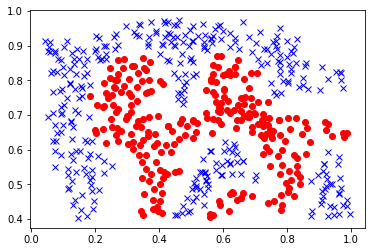

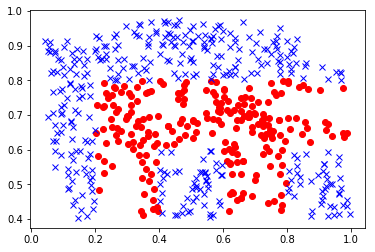

In [97]:
plt.plot(df_sub1['x1'],df_sub1['x2'],'ro')
plt.plot(df_sub2['x1'],df_sub2['x2'],'bx')

count_right=0
count_wrong=0
for index, xy in df_trained_mv2.iterrows():
    if xy['y'] == df.iloc[index]['y']:
        count_right+=1
    else :
        count_wrong+=1
        
print(count_right/(count_right+count_wrong))
plt.figure()
df_sub11 = df_trained_mv2[df_trained_mv2['y'] == 0]
df_sub22 = df_trained_mv2[df_trained_mv2['y'] == 1]
plt.plot(df_sub11['x1'],df_sub11['x2'],'ro')
plt.plot(df_sub22['x1'],df_sub22['x2'],'bx')

0.8217993079584776


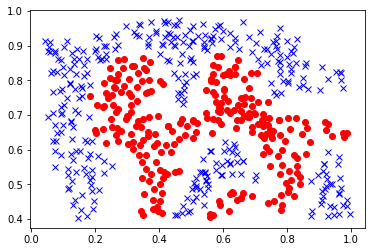

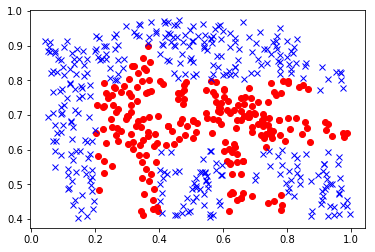

In [100]:
plt.plot(df_sub1['x1'],df_sub1['x2'],'ro')
plt.plot(df_sub2['x1'],df_sub2['x2'],'bx')

count_right=0
count_wrong=0
for index, xy in df_trained_mv2.iterrows():
    if xy['y'] == df.iloc[index]['y']:
        count_right+=1
    else :
        count_wrong+=1
        
print(count_right/(count_right+count_wrong))
plt.figure()
df_sub11 = df_trained_mv2[df_trained_mv2['y'] == 0]
df_sub22 = df_trained_mv2[df_trained_mv2['y'] == 1]
plt.plot(df_sub11['x1'],df_sub11['x2'],'ro')
plt.plot(df_sub22['x1'],df_sub22['x2'],'bx')

In [ ]:
############ here is 2d method

In [87]:
NB = NaiveBayesClassifier_cont_input(k = 0.5, method = 'equal_partition_2d',partitionN=10)
NB.fit(df_x,df_y)


[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.50920245]
 [0.5        0.51840491]
 [0.5        0.52147239]
 [0.5        0.53067485]
 [0.5        0.50613497]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.53680982]
 [0.5        0.54601227]
 [0.50396825 0.52760736]
 [0.50396825 0.53680982]
 [0.5        0.54907975]
 [0.5        0.50306748]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.50306748]
 [0.5        0.51226994]
 [0.53968254 0.5       ]
 [0.55555556 0.5       ]
 [0.53174603 0.52760736]
 [0.5        0.51840491]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.53174603 0.5       ]
 [0.53174603 0.5       ]
 [0.57539683 0.5       ]
 [0.53968254 0.5       ]
 [0.53571429 0.50306748]
 [0.5        0.53067485]


In [93]:
r_y = []
for index, xx in df_x.iterrows():
  #  print(xx)
   # print(xx[0])
    prob1 = NB.classify(xx)
    if prob1 >= 0.5:
        r_y.append (1)
    else:
        r_y.append (0)

df_ry = pd.DataFrame(r_y,columns=['y'])
df_trained_mv2 = pd.concat([df_x, df_ry], axis=1)

0.0 0.09202453987730061
1.0
0.21031746031746001 0.0
0.0
0.06746031746031746 0.10429447852760734
0.6666666666666665
0.007936507936507936 0.10429447852760734
0.9444444444444444
0.007936507936507936 0.10429447852760734
0.9444444444444444
0.21031746031746001 0.0
0.0
0.06746031746031746 0.07975460122699388
0.6046511627906976
0.04365079365079365 0.08588957055214724
0.7179487179487178
0.0 0.09202453987730061
1.0
0.21031746031746001 0.0
0.0
0.023809523809523808 0.1564417177914111
0.8947368421052632
0.0 0.09202453987730061
1.0
0.007936507936507936 0.10429447852760734
0.9444444444444444
0.06349206349206349 0.015337423312883436
0.23809523809523805
0.05555555555555555 0.02147239263803681
0.3333333333333333
0.0 0.05828220858895708
1.0
0.023809523809523808 0.1564417177914111
0.8947368421052632
0.06746031746031746 0.07975460122699388
0.6046511627906976
0.21031746031746001 0.0
0.0
0.0 0.08895705521472393
1.0
0.06746031746031746 0.07975460122699388
0.6046511627906976
0.0873015873015873 0.03987730061349

0.13492063492063489 0.024539877300613498
0.19047619047619052
0.047619047619047616 0.10122699386503066
0.7333333333333333
0.023809523809523808 0.1564417177914111
0.8947368421052632
0.0 0.09202453987730061
1.0
0.0 0.08895705521472393
1.0
0.04365079365079365 0.08588957055214724
0.7179487179487178
0.06746031746031746 0.10429447852760734
0.6666666666666665
0.0 0.05828220858895708
1.0
0.0873015873015873 0.03987730061349694
0.37142857142857144
0.007936507936507936 0.10429447852760734
0.9444444444444444
0.06746031746031746 0.10429447852760734
0.6666666666666665
0.04365079365079365 0.08588957055214724
0.7179487179487178
0.13492063492063489 0.024539877300613498
0.19047619047619052
0.06349206349206349 0.015337423312883436
0.23809523809523805
0.023809523809523808 0.1564417177914111
0.8947368421052632
0.007936507936507936 0.10429447852760734
0.9444444444444444
0.06349206349206349 0.015337423312883436
0.23809523809523805
0.04365079365079365 0.08588957055214724
0.7179487179487178
0.047619047619047616

0.13492063492063489 0.024539877300613498
0.19047619047619052
0.0873015873015873 0.03987730061349694
0.37142857142857144
0.06746031746031746 0.10429447852760734
0.6666666666666665
0.0 0.05828220858895708
1.0
0.0 0.08895705521472393
1.0
0.0 0.08895705521472393
1.0
0.06349206349206349 0.015337423312883436
0.23809523809523805
0.0873015873015873 0.03987730061349694
0.37142857142857144
0.06746031746031746 0.07975460122699388
0.6046511627906976
0.19047619047619024 0.027607361963190184
0.15789473684210542
0.0 0.08895705521472393
1.0
0.06746031746031746 0.10429447852760734
0.6666666666666665
0.0 0.08895705521472393
1.0
0.04365079365079365 0.08588957055214724
0.7179487179487178
0.19047619047619024 0.027607361963190184
0.15789473684210542
0.19047619047619024 0.027607361963190184
0.15789473684210542
0.0 0.08895705521472393
1.0
0.0 0.09202453987730061
1.0
0.06746031746031746 0.07975460122699388
0.6046511627906976
0.21031746031746001 0.0
0.0
0.023809523809523808 0.1564417177914111
0.8947368421052632

0.13492063492063489 0.024539877300613498
0.19047619047619052
0.06746031746031746 0.07975460122699388
0.6046511627906976
0.13492063492063489 0.024539877300613498
0.19047619047619052
0.21031746031746001 0.0
0.0
0.19047619047619024 0.027607361963190184
0.15789473684210542
0.04365079365079365 0.08588957055214724
0.7179487179487178
0.19047619047619024 0.027607361963190184
0.15789473684210542
0.19047619047619024 0.027607361963190184
0.15789473684210542
0.21031746031746001 0.0
0.0
0.007936507936507936 0.10429447852760734
0.9444444444444444
0.06746031746031746 0.10429447852760734
0.6666666666666665
0.0 0.09202453987730061
1.0
0.0 0.08895705521472393
1.0
0.0873015873015873 0.03987730061349694
0.37142857142857144
0.06349206349206349 0.015337423312883436
0.23809523809523805
0.19047619047619024 0.027607361963190184
0.15789473684210542
0.06746031746031746 0.07975460122699388
0.6046511627906976
0.06746031746031746 0.07975460122699388
0.6046511627906976
0.06746031746031746 0.07975460122699388
0.60465

0.8148788927335641


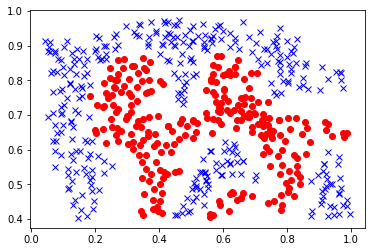

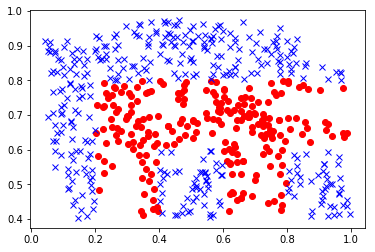

In [94]:
plt.plot(df_sub1['x1'],df_sub1['x2'],'ro')
plt.plot(df_sub2['x1'],df_sub2['x2'],'bx')

count_right=0
count_wrong=0
for index, xy in df_trained_mv2.iterrows():
    if xy['y'] == df.iloc[index]['y']:
        count_right+=1
    else :
        count_wrong+=1
        
print(count_right/(count_right+count_wrong))
plt.figure()
df_sub11 = df_trained_mv2[df_trained_mv2['y'] == 0]
df_sub22 = df_trained_mv2[df_trained_mv2['y'] == 1]
plt.plot(df_sub11['x1'],df_sub11['x2'],'ro')
plt.plot(df_sub22['x1'],df_sub22['x2'],'bx')